# Check and register existing (BBP) simulation campaigns to entitycore

In [1]:
import h5py
import json
import numpy as np
import subprocess
from bluepysnap import Circuit, Simulation
from datetime import datetime, UTC
from entitysdk import Client, ProjectContext, models, types
from entitysdk.staging.circuit import stage_circuit
from entitysdk.staging.simulation_result import stage_simulation, stage_simulation_result
from itertools import product
from libsonata import SimulationConfig
from obi_auth import get_token
from pathlib import Path

In [21]:
SIM_ROOT = Path("/Users/pokorny/Data/Simulations/BBP-curated")
CIRCUIT_ROOT = Path("/Users/pokorny/Data/Circuits")

SIM_CONFIG_NAME = "simulation_config.json"
CIRCUIT_CONFIG_NAME = "circuit_config.json"

AWS_S3 = "s3://openbluebrain/"

# Options to upload assets directly from AWS S3
use_aws_spike_assets = True
use_aws_voltage_assets = True
use_aws_replay_assets = False

### Campaign specification
- Campaign path assumed to be `<SIM_ROOT>/<name>`
- Circuit path assumed to be `<CIRCUIT_ROOT>/<circuit>`

In [3]:
# Campaign info & metadata
# sim_campaign = {
#     "campaign_name": "BBP-SM-whisker-soma",
#     "campaign_description": "BBP campaign consisting of a single simulation of the nbS1-O1-SM (Schneider-Mizell) circuit with whisker flick stimulation on VPM fibers, incl. soma recording.",
#     "folder_name": "SM-whisker-soma",
#     "campaign_config": "config.json",
#     "gpfs_path": "/gpfs/bbp.cscs.ch/project/proj83/home/isbister/simulations/elife_sscx_physiology_2024/9-SchneiderMizell/2_whisker_deflections_soma/2_whisker_deflections_soma_0__19_11_24",
#     "aws_path": "Simulation_data/Simulation_Campaigns/Rat/SSCx/f132b97aa0",
#     "aws_inputs": "e6efa007-e7fa-42ae-ae3d-53385ec57154",  # Subfolder with spike replay inputs
#     "circuit": "nbS1-O1-SM"
# }

sim_campaign = {
    "campaign_name": "BBP-SM-whisker-scan",
    "campaign_description": "BBP campaign consisting of 72 simulations of the nbS1-O1-SM (Schneider-Mizell) circuit with whisker flick stimulation on VPM fibers, scanned over different values of calcium, Ornstein-Uhlenbeck std to mean ratio R_OU, in-vivo firing rate proportion P_FR, and percentage of VPM fibers. Related publication: Isbister et al., 2025 (DOI: 10.7554/eLife.99693.2)",
    "folder_name": "SM-whisker-scan",
    "campaign_config": "config.json",
    "gpfs_path": "/gpfs/bbp.cscs.ch/project/proj83/home/isbister/simulations/elife_sscx_physiology_2024/9-SchneiderMizell/1_whisker_deflections/1_3_whisker_deflections_scan_16_4_24",
    "aws_path": "staging/Simulation_data/Simulation_Campaigns/Rat/SSCx/3f6517825f",
    "aws_inputs": "518fbeaf-f0ba-4f99-a0ff-22cb7e89eed7",  # Subfolder with spike replay inputs
    "circuit": "nbS1-O1-SM"
}



---
### 1. Check input paths
- Assuming individual simulation subfolders `/0`, `/1`, ... (= index)
- Assuming `"simulation_config.json"` within each subfolder

In [4]:
# Check folders
campaign_path = SIM_ROOT / sim_campaign["folder_name"]
circuit_path = CIRCUIT_ROOT / sim_campaign["circuit"]

assert campaign_path.is_dir(), "ERROR: Simulation path not found!"
assert circuit_path.is_dir(), "ERROR: Circuit path not found!"

In [5]:
# Check sub-folders
sim_folders = list(campaign_path.glob("*[0-9]"))
sim_folder_names = [f.name for f in sim_folders]
num_sims = len(sim_folders)
print(f"Found {num_sims} simulation(s) in campaign '{sim_campaign['folder_name']}'")
assert all(str(idx) in sim_folder_names for idx in range(num_sims)), "ERROR: Subfolder names do not match simulation indices!"

Found 72 simulation(s) in campaign 'SM-whisker-scan'


In [6]:
# Check simulation configs
sim_configs = [_dir / SIM_CONFIG_NAME for _dir in sim_folders]
orig_circuit = None
for cfg in sim_configs:
    assert cfg.is_file(), f"ERROR: Simulation config '{sim_config}' not found!"
    with open(cfg, "r") as f:
        cfg_dict = json.load(f)
    if orig_circuit is None:
        orig_circuit = cfg_dict["network"]
    else:
        assert cfg_dict["network"] == orig_circuit, "ERROR: Circuit mismatch!"

In [7]:
# Check circuit config
circuit_config = circuit_path / CIRCUIT_CONFIG_NAME
assert circuit_config.is_file(), f"ERROR: Circuit config '{circuit_config}' not found!"
print(f"Original circuit:     '{orig_circuit}'")
print(f"New campaign circuit: '{circuit_config}'")

Original circuit:     '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/InterneuronRewiringO1/circuits/SSCx-HexO1-Release__O1_Schneider_Mizell_v2/circuit_config_reparam_tc.json'
New campaign circuit: '/Users/pokorny/Data/Circuits/nbS1-O1-SM/circuit_config.json'


In [18]:
# Check AWS path (optional)
if sim_campaign.get("aws_path"):
    aws_out = subprocess.check_output(f"aws s3 ls {AWS_S3 + sim_campaign['aws_path']}/ --no-sign-request --human-readable --recursive", shell=True, text=True)
    print(aws_out.split("\n")[0])
    print("...")
    print(aws_out.split("\n")[-2])
else:
    aws_out = None

2024-11-28 03:00:03  522.1 KiB staging/Simulation_data/Simulation_Campaigns/Rat/SSCx/3f6517825f/0/reporting/spikes.h5
...
2024-11-28 03:00:11    5.7 KiB staging/Simulation_data/Simulation_Campaigns/Rat/SSCx/3f6517825f/9/simulation_config.json


### 2. Check simulation contents

In [19]:
def read_spikes(h5_file, population_name):
    with h5py.File(h5_file, "r") as h5:
        nids = h5[f"spikes/{population_name}"]["node_ids"][:]
        ts = h5[f"spikes/{population_name}"]["timestamps"][:]
    return nids, ts, np.unique(nids)

In [22]:
c = Circuit(circuit_config)
spike_files = []
voltage_reports = []
replay_files = []
for idx, cfg in enumerate(sim_configs):
    sim = Simulation(cfg)
    output_dir = Path(sim.config["output"]["output_dir"])
    node_set = sim.config["node_set"]
    print(f"SIMULATION {idx}")
    print(f"  Simulation length: {sim.time_start}-{sim.time_stop}ms")

    # Check populations
    npop = sim.spikes.population_names
    assert len(npop) == 1, "ERROR: Only one node population expected!"
    npop = npop[0]
    assert npop in c.nodes.population_names, f"ERROR: Node population '{npop}' not found in circuit!"
    print(f"  Population name: '{npop}'")
    
    # Check output spikes
    spike_file = Path(sim.spikes.config.output_dir) / sim.spikes.config.spikes_file
    nids, ts, unique_nids = read_spikes(spike_file, npop)
    assert np.all(np.isin(unique_nids, c.nodes[npop].ids(node_set))), f"ERROR: Node ID mismatch in '{spike_file}'!"
    print(f"  Node set: {node_set} ({len(c.nodes[npop].ids(node_set))} neurons)")
    print(f"  Node IDs: {min(nids)}-{max(nids)} ({len(unique_nids)} spiking neurons)")
    print(f"  Time stamps {min(ts):.1f}-{max(ts):.1f}ms")
    print(f"  #Spikes: {len(nids)}")
    if use_aws_spike_assets and aws_out:
        spike_file = str(Path(sim_campaign["aws_path"]) / spike_file.relative_to(campaign_path))
        assert spike_file in aws_out, f"ERROR: Spike file '{spike_file}' not found on {AWS_S3}!"
        print(f"  AWS: {spike_file}")
    spike_files.append(spike_file)

    # Check voltage reports (if any)
    report_files = []
    for report in sim.reports.values():
        report_file = output_dir / (report.name + ".h5")
        report_node_set = report.node_set
        with h5py.File(report_file, "r") as h5:
            nids = h5[f"report/{npop}/mapping"]["node_ids"][:]
        assert np.all(np.isin(nids, c.nodes[npop].ids(report_node_set))), f"ERROR: Node ID mismatch in '{report_file}'!"
        print(f"  Report '{report.name}':")
        print(f"    Node set: {report_node_set} ({len(c.nodes[npop].ids(report_node_set))} neurons)")
        print(f"    Node IDs: {min(nids)}-{max(nids)} ({len(np.unique(nids))} recorded neurons)")
        print(f"    Length: {report.time_start}-{report.time_stop}ms")
        if use_aws_voltage_assets and aws_out:
            report_file = str(Path(sim_campaign["aws_path"]) / report_file.relative_to(campaign_path))
            assert report_file in aws_out, f"ERROR: Report file '{report_file}' not found on {AWS_S3}!"
            print(f"    AWS: {report_file}")
        report_files.append(report_file)
    voltage_reports.append(report_files)

    # Check input spikes (if any)
    inp_files = []
    for inp_name, inp in sim.inputs.items():
        if not inp.input_type == SimulationConfig.InputBase.InputType.spikes:
            continue
        inp_spike_file = inp.spike_file
        print(f"  Spike input '{inp_name}':")
        inp_pop = inp.reader.get_population_names()
        assert len(inp_pop) == 1, "ERROR: Only one input node population expected!"
        inp_pop = inp_pop[0]
        inp_node_set = inp.node_set
        assert inp_pop in c.nodes.population_names, f"ERROR: Input node population '{inp_pop}' not found in circuit!"
        print(f"    Source population: '{inp_pop}'")
        assert inp_node_set in c.node_sets.content, f"ERROR: Input node set '{inp_node_set}' not found in circuit!"
        print(f"    Target node set: '{inp_node_set}'")
        inp_nids, inp_ts, unique_inp_nids = read_spikes(inp_spike_file, inp_pop)
        assert np.all(np.isin(unique_inp_nids, c.nodes[inp_pop].ids())), f"ERROR: Input node ID mismatch in '{inp_spike_file}'!"
        print(f"    Node IDs: {min(inp_nids)}-{max(inp_nids)} ({len(unique_inp_nids)} spiking neurons)")
        print(f"    Time stamps {min(inp_ts):.1f}-{max(inp_ts):.1f}ms")
        print(f"    #Spikes: {len(inp_nids)}")
        if use_aws_replay_assets and aws_out:
            inp_sub = sim_campaign.get("aws_inputs", "")
            inp_spike_file = str(Path(sim_campaign["aws_path"]) / inp_sub / Path(inp_spike_file).relative_to(campaign_path))
            assert inp_spike_file in aws_out, f"ERROR: Replay file '{inp_spike_file}' not found on {AWS_S3}!"
            print(f"    AWS: {inp_spike_file}")
        inp_files.append(inp_spike_file)
    replay_files.append(inp_files)

    print()


SIMULATION 0
  Simulation length: 0-2500.0ms
  Population name: 'S1nonbarrel_neurons'
  Node set: hex_O1 (211712 neurons)
  Node IDs: 82-211711 (16105 spiking neurons)
  Time stamps 44.0-2499.9ms
  #Spikes: 37483
  AWS: staging/Simulation_data/Simulation_Campaigns/Rat/SSCx/3f6517825f/61/reporting/spikes.h5
  Spike input 'Stimulus spikeReplay':
    Source population: 'VPM'
    Target node set: 'hex_O1'
    Node IDs: 2609-12416 (59 spiking neurons)
    Time stamps 1503.3-2009.4ms
    #Spikes: 188

SIMULATION 1
  Simulation length: 0-2500.0ms
  Population name: 'S1nonbarrel_neurons'
  Node set: hex_O1 (211712 neurons)
  Node IDs: 6-211711 (121196 spiking neurons)
  Time stamps 44.0-2500.0ms
  #Spikes: 370681
  AWS: staging/Simulation_data/Simulation_Campaigns/Rat/SSCx/3f6517825f/59/reporting/spikes.h5
  Spike input 'Stimulus spikeReplay':
    Source population: 'VPM'
    Target node set: 'hex_O1'
    Node IDs: 2505-12393 (92 spiking neurons)
    Time stamps 1503.0-2009.4ms
    #Spikes: 28

### 3. Check campaign config

In [23]:
# Check campaign config
campaign_config_file = campaign_path / sim_campaign["campaign_config"]
with open(campaign_config_file, "r") as f:
    campaign_config_dict = json.load(f)

In [24]:
# Campaign scan params dict
scan_params = {k: v["data"] for k, v in campaign_config_dict["coords"].items()}
scan_indices = {k: list(range(len(v))) for k, v in scan_params.items()}
print("Campaign param dict:")
print(scan_params)

Campaign param dict:
{'ca': [1.05, 1.1], 'depol_stdev_mean_ratio': [0.2, 0.3, 0.4], 'desired_connected_proportion_of_invivo_frs': [0.1, 0.3, 0.5, 0.7], 'vpm_pct': [5.0, 10.0, 15.0]}


In [26]:
# Single scan params list
single_params = list(product(*scan_params.values()))
single_indices = list(product(*scan_indices.values()))

In [27]:
# Check consistency with folders
for idx, scan_idx in enumerate(single_indices):
    data = campaign_config_dict["data"]
    for _i in scan_idx:
        data = data[_i]
    assert Path(data).name == str(idx), f"ERROR: Index {idx} mismatch ({scan_idx})!"

In [28]:
# Single scan param dicts
dims = campaign_config_dict["dims"]
assert list(scan_params.keys()) == dims, "ERROR: Dims mismtach!"
single_scan_params = [{dims[_d]: single_params[_i][_d] for _d in range(len(dims))} for _i in range(len(single_params))]
print("Single param dict(s):")
print(single_scan_params[0])
if len(single_scan_params) > 2:
    print("...")
if len(single_scan_params) > 1:
    print(single_scan_params[-1])

Single param dict(s):
{'ca': 1.05, 'depol_stdev_mean_ratio': 0.2, 'desired_connected_proportion_of_invivo_frs': 0.1, 'vpm_pct': 5.0}
...
{'ca': 1.1, 'depol_stdev_mean_ratio': 0.4, 'desired_connected_proportion_of_invivo_frs': 0.7, 'vpm_pct': 15.0}


### 4. Create and register `Simulation`, `SimulationCampaign`, and `SimulationResult` entities

In [29]:
authorized_public = False

In [30]:
token = get_token(environment="staging")
# project_context = ProjectContext.from_vlab_url("https://staging.openbraininstitute.org/app/virtual-lab/lab/1f91f30e-1489-4e2a-8eb7-1217257c8e19/project/7a411785-6895-4839-aaa2-d9f76e09875a/home")
project_context = ProjectContext.from_vlab_url("https://staging.openbraininstitute.org/app/virtual-lab/lab/e6030ed8-a589-4be2-80a6-f975406eb1f6/project/2720f785-a3a2-4472-969d-19a53891c817")
client = Client(environment="staging", project_context=project_context, token_manager=token)

In [31]:
# Get circuit entity
circuit_entity = client.search_entity(entity_type=models.Circuit, query={"name": sim_campaign["circuit"]}).one()
print(f"Circuit '{circuit_entity.name}' (ID {circuit_entity.id})")

Circuit 'nbS1-O1-SM' (ID 28049bf1-2082-4fa5-a6d6-540497da6d54)


In [32]:
# Create and register SimulationCampaign entity + asset (config.json)
campaign_model = models.SimulationCampaign(
    name=sim_campaign["campaign_name"],
    description=sim_campaign["campaign_description"],
    entity_id=circuit_entity.id,
    scan_parameters=scan_params,
    authorized_public=authorized_public,
)
campaign_entity = client.register_entity(campaign_model)
print(f"Registered SimulationCampaign '{campaign_entity.name}' (ID {campaign_entity.id})")

campaign_asset = client.upload_file(
    entity_id=campaign_entity.id,
    entity_type=models.SimulationCampaign,
    file_path=campaign_config_file,
    file_content_type="application/json",
    asset_label="campaign_summary",
)
print(f"Uploaded '{campaign_asset.label}' asset for campaign '{campaign_entity.name}' (ID {campaign_asset.id})")

Registered SimulationCampaign 'BBP-SM-whisker-scan' (ID 4dbc44a3-90ea-4e3b-a53e-62417635e91d)
Uploaded 'campaign_summary' asset for campaign 'BBP-SM-whisker-scan' (ID 5fc9dab8-b152-40c2-bb29-c330c0fef244)


In [ ]:
# Create and register Simulation entities + asset (SONATA config) and SimulationResult + assets
for idx, param_dict in enumerate(single_scan_params):
    ###############################################################################################
    # Simulation
    ###############################################################################################
    sim_model = models.Simulation(
        name=f"simulation_{idx}",
        description=f"Simulation {idx}",
        scan_parameters=param_dict,
        entity_id=circuit_entity.id,
        simulation_campaign_id=campaign_entity.id,
        authorized_public=authorized_public,
    )

    sim_entity = client.register_entity(sim_model)
    print(f"Registered Simulation '{sim_entity.name}' (ID {sim_entity.id})")

    sim_cfg_asset = client.upload_file(
        entity_id=sim_entity.id,
        entity_type=models.Simulation,
        file_path=sim_configs[idx],
        file_content_type="application/json",
        asset_label="sonata_simulation_config",
    )
    print(f"  > Uploaded '{sim_cfg_asset.path}' as '{sim_cfg_asset.label}' asset (ID {sim_cfg_asset.id})")

    # REPLAY ASSETS
    asset_label = "replay_spikes"
    content_type = "application/x-hdf5"
    for repl in replay_files[idx]:
        if use_aws_replay_assets:
            sim_replay_asset = client.register_asset(
                entity_id=sim_entity.id,
                entity_type=models.Simulation,
                name=Path(repl).name,
                storage_path=repl,
                storage_type="aws_s3_open",
                is_directory=False,
                content_type=content_type,
                asset_label=asset_label,
            )
            msg = "Registered from AWS-S3"
        else:
            sim_replay_asset = client.upload_file(
                entity_id=sim_entity.id,
                entity_type=models.Simulation,
                file_path=repl,
                file_content_type=content_type,
                asset_label=asset_label,
            )
            msg = "Uploaded"
        print(f"  > {msg} '{sim_replay_asset.path}' as '{sim_replay_asset.label}' asset (ID {sim_replay_asset.id})")

    # CUSTOM NODE SET FILE
    # TODO: Use real file instead of empty dummy!
    nset_file = Path("./TMP/node_sets.json")
    nset_file.parent.mkdir(exist_ok=True, parents=True)
    with open(nset_file, "w") as f:
        json.dump({}, f)
    nset_asset = client.upload_file(
        entity_id=sim_entity.id,
        entity_type=models.Simulation,
        file_path=nset_file,
        file_content_type="application/json",
        asset_label="custom_node_sets",
    )
    print(f"  > Uploaded '{nset_asset.path}' as '{nset_asset.label}' asset (ID {nset_asset.id})")

    ###############################################################################################
    # SimulationResult
    ###############################################################################################
    sim_res_model = models.SimulationResult(
        name="simulation_result",
        description="Simulation result",
        simulation_id=sim_entity.id,
        authorized_public=authorized_public,
    )
    sim_res_entity = client.register_entity(sim_res_model)
    print(f"Registered SimulationResult '{sim_res_entity.name}' (ID {sim_res_entity.id})")

    # SPIKE ASSET
    asset_label = "spike_report"
    content_type = "application/x-hdf5"
    if use_aws_spike_assets:
        res_spk_asset = client.register_asset(
            entity_id=sim_res_entity.id,
            entity_type=models.SimulationResult,
            name=Path(spike_files[idx]).name,
            storage_path=spike_files[idx],
            storage_type="aws_s3_open",
            is_directory=False,
            content_type=content_type,
            asset_label=asset_label,
        )
        msg = "Registered from AWS-S3"
    else:
        res_spk_asset = client.upload_file(
            entity_id=sim_res_entity.id,
            entity_type=models.SimulationResult,
            file_path=spike_files[idx],
            file_content_type=content_type,
            asset_label=asset_label,
        )
        msg = "Uploaded"
    print(f"  > {msg} '{res_spk_asset.path}' as '{res_spk_asset.label}' asset (ID {res_spk_asset.id})")

    # VOLTAGE REPORT ASSETS
    asset_label = "voltage_report"
    content_type = "application/x-hdf5"
    for vrep in voltage_reports[idx]:
        if use_aws_voltage_assets:
            res_vrep_asset = client.register_asset(
                entity_id=sim_res_entity.id,
                entity_type=models.SimulationResult,
                name=Path(vrep).name,
                storage_path=vrep,
                storage_type="aws_s3_open",
                is_directory=False,
                content_type=content_type,
                asset_label=asset_label,
            )
            msg = "Registered from AWS-S3"
        else:
            res_vrep_asset = client.upload_file(
                entity_id=sim_res_entity.id,
                entity_type=models.SimulationResult,
                file_path=vrep,
                file_content_type=content_type,
                asset_label=asset_label,
            )
            msg = "Uploaded"
        print(f"  > {msg} '{res_vrep_asset.path}' as '{res_vrep_asset.label}' asset (ID {res_vrep_asset.id})")

    ###############################################################################################
    # SimulationExecution(Activity): Required to retrieve a SimulationResult for a given Simulation
    ###############################################################################################

    now = datetime.now(UTC)
    sim_exec_model = models.SimulationExecution(
        start_time=now,
        end_time=now,
        used=[sim_entity],
        generated=[sim_res_entity],
        status=types.SimulationExecutionStatus.done,
        authorized_public=authorized_public,
    )
    sim_exec_entity = client.register_entity(sim_exec_model)
    print(f"Registered SimulationExecution (ID {sim_exec_entity.id})")
    print()

### 5. Check registered campaign

In [34]:
registered_campaign = client.get_entity(entity_id=campaign_entity.id, entity_type=models.SimulationCampaign)
# OR
# registered_campaign = client.search_entity(entity_type=models.SimulationCampaign, query={"name": sim_campaign["campaign_name"]}).one()
print(f"Found campaign '{registered_campaign.name}' (ID {registered_campaign.id})")

Found campaign 'BBP-SM-whisker-scan' (ID 4dbc44a3-90ea-4e3b-a53e-62417635e91d)


In [57]:
print(f"SimulationCampaign '{registered_campaign.name}' (ID {registered_campaign.id})")
for a in registered_campaign.assets:
    print(f"  - Asset '{a.label}' ({a.id})")

for sim in registered_campaign.simulations:
    sim = client.get_entity(entity_id=sim.id, entity_type=models.Simulation)  # To get assets!!
    print(f"  > Simulation '{sim.name}' (ID {sim.id})")
    for a in sim.assets:
        print(f"    - Asset '{a.label}' ({a.id})")
    sim_exec = client.search_entity(entity_type=models.SimulationExecution, query={"used__id": sim.id}).one()
    print(f"    > SimulationExecution activity (ID {sim.id})")
    sim_res = client.get_entity(entity_id=sim_exec.generated[0].id, entity_type=models.SimulationResult)
    print(f"    > SimulationResult '{sim_res.name}' (ID {sim.id})")
    for a in sim_res.assets:
        print(f"      - Asset '{a.label}' ({a.id})")

SimulationCampaign 'BBP-SM-whisker-scan' (ID 4dbc44a3-90ea-4e3b-a53e-62417635e91d)
  - Asset 'campaign_summary' (5fc9dab8-b152-40c2-bb29-c330c0fef244)
  > Simulation 'Simulation 0' (ID e0aa6fc5-f274-4f77-8599-40bf07c29cc2)
    - Asset 'custom_node_sets' (b6016522-56ce-4f07-8271-904d801369d2)
    - Asset 'sonata_simulation_config' (601df20c-24cf-483a-85fd-a380b830bbe8)
    - Asset 'replay_spikes' (b10c8780-4e53-4f30-935c-1a642755eebc)
    > SimulationExecution activity (ID e0aa6fc5-f274-4f77-8599-40bf07c29cc2)
    > SimulationResult 'simulation_result' (ID e0aa6fc5-f274-4f77-8599-40bf07c29cc2)
      - Asset 'spike_report' (2d1aa19d-6158-44f4-8d4f-faa190887376)
  > Simulation 'Simulation 1' (ID 67506a5b-a183-4ba6-833e-64de18088b80)
    - Asset 'sonata_simulation_config' (fb61ada9-7d1f-457e-a43b-aa1f35fe5160)
    - Asset 'replay_spikes' (1112b233-660f-454d-923d-659ae6a88aef)
    - Asset 'custom_node_sets' (d8d6d8f0-f7d1-403d-a665-fe8aecfbaf8b)
    > SimulationExecution activity (ID 67506a

### 6. Stage circuit & campaign in local folder

In [58]:
CIRCUIT_STAGING_ROOT = Path("./STAGING/circuits")
CAMPAIGN_STAGING_ROOT = Path("./STAGING/simulation_campaigns")

In [71]:
def stage_campaign_circuit(simulation_campaign_id, output_root):
    """Stage the circuit of a simulation campaign, incl. caching."""
    # Get circuit ID from simulation campaign
    simulation_campaign = client.get_entity(entity_type=models.SimulationCampaign, entity_id=simulation_campaign_id)
    circuit_id = str(simulation_campaign.entity_id)
    circuit_entity = client.get_entity(entity_type=models.Circuit, entity_id=circuit_id)

    # Stage circuit or use from cache
    output_dir = Path(output_root).resolve() / circuit_id
    if output_dir.exists():
        print(f"INFO: Using cached circuit '{circuit_entity.name}'")
        circuit_config_path = output_dir / "circuit_config.json"
    else:
        circuit_config_path = stage_circuit(
            client=client,
            model=circuit_entity,
            output_dir=output_dir,
            max_concurrent=4,
        )
    assert circuit_config_path.is_file(), "ERROR: Circuit staging error - clear cache and retry!"
    print(f"INFO: Staged circuit '{circuit_entity.name}' at {circuit_config_path}")

    return circuit_config_path

def stage_sim_campaign(simulation_campaign_id, output_root, circuit_config_path):
    """Stage the simulation campaign w/o circuit, incl. caching."""
    simulation_campaign = client.get_entity(entity_type=models.SimulationCampaign, entity_id=simulation_campaign_id)
    simulation_config_paths = []
    for simulation in simulation_campaign.simulations:
        # IMPORTANT: The order of simulations returned by simulation_campaign.simulations is not necessarily ordered!!

        simulation = client.get_entity(entity_id=simulation.id, entity_type=models.Simulation)  # Required to get assets!!

        # Stage simulation + result or use from cache
        sim_dir = simulation.name.replace(" ", "_").lower()
        output_dir = Path(output_root).resolve() / str(simulation_campaign_id) / sim_dir
        if output_dir.exists():
            print(f"INFO: Using cached simulation '{simulation.name}'")
            simulation_config_path = output_dir / "simulation_config.json"
        else:
            # Stage simulation
            simulation_config_path = stage_simulation(
                client=client,
                model=simulation,
                output_dir=output_dir,
                circuit_config_path=circuit_config_path,
            )

            # Get simulation execution and stage simulation result
            simulation_executions = client.search_entity(
                entity_type=models.SimulationExecution,
                query={"used__id": simulation.id}
            ).all()

            if len(simulation_executions) == 0:
                print(f"WARNING: No SimulationExecution/Result found for Simulation ID {simulation.id}")
            else:
                simulation_execution = simulation_executions[0]
                simulation_result_id = simulation_execution.generated[0].id
                simulation_result = client.get_entity(entity_type=models.SimulationResult, entity_id=simulation_result_id)

                _ = stage_simulation_result(
                    client=client,
                    model=simulation_result,
                    output_dir=output_dir,
                    simulation_config_file=simulation_config_path,
                )
        
        assert simulation_config_path.is_file(), "ERROR: Simulation staging error - clear cache and retry!"
        print(f"INFO: Staged simulation '{simulation.name}' at {simulation_config_path}")

        simulation_config_paths.append(str(simulation_config_path))

    print(f"INFO: Staged campaign '{simulation_campaign.name}' with {len(simulation_config_paths)} simulation(s)")

    return simulation_config_paths


In [72]:
staged_circuit_config = stage_campaign_circuit(
    simulation_campaign_id=registered_campaign.id,
    output_root=CIRCUIT_STAGING_ROOT,
)

INFO: Using cached circuit 'nbS1-O1-SM'
INFO: Staged circuit 'nbS1-O1-SM' at /Users/pokorny/JupyterLab/git/obi-one/projects/sim_campaign_upload/STAGING/circuits/28049bf1-2082-4fa5-a6d6-540497da6d54/circuit_config.json


In [73]:
staged_sim_configs = stage_sim_campaign(
    simulation_campaign_id=registered_campaign.id,
    output_root=CAMPAIGN_STAGING_ROOT,
    circuit_config_path=staged_circuit_config
)

INFO: Staged simulation 'Simulation 0' at /Users/pokorny/JupyterLab/git/obi-one/projects/sim_campaign_upload/STAGING/simulation_campaigns/4dbc44a3-90ea-4e3b-a53e-62417635e91d/simulation_0/simulation_config.json
INFO: Staged simulation 'Simulation 1' at /Users/pokorny/JupyterLab/git/obi-one/projects/sim_campaign_upload/STAGING/simulation_campaigns/4dbc44a3-90ea-4e3b-a53e-62417635e91d/simulation_1/simulation_config.json
INFO: Staged simulation 'Simulation 2' at /Users/pokorny/JupyterLab/git/obi-one/projects/sim_campaign_upload/STAGING/simulation_campaigns/4dbc44a3-90ea-4e3b-a53e-62417635e91d/simulation_2/simulation_config.json
INFO: Staged simulation 'Simulation 3' at /Users/pokorny/JupyterLab/git/obi-one/projects/sim_campaign_upload/STAGING/simulation_campaigns/4dbc44a3-90ea-4e3b-a53e-62417635e91d/simulation_3/simulation_config.json
INFO: Staged simulation 'Simulation 4' at /Users/pokorny/JupyterLab/git/obi-one/projects/sim_campaign_upload/STAGING/simulation_campaigns/4dbc44a3-90ea-4e3b

### 7. Plot spikes

In [85]:
def plot_spikes(simulation_config_paths):
    for simulation_config_path in simulation_config_paths:
        # print(f"Processing simulation config path: {simulation_config_path}")
        
        # Plot and print the spikes
        snap_simulation = Simulation(simulation_config_path)
        spikes = snap_simulation.spikes
        spikes.filter().raster()

        # print(spikes.population_names)
        # for population in spikes.population_names:
        #     population_spikes = spikes[population]
        #     print(population_spikes.get())


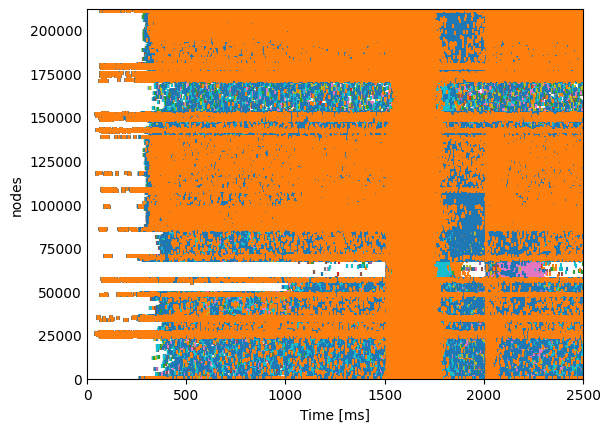

In [86]:
plot_spikes(staged_sim_configs)